In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [20]:
import glob
import h5py
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.stats import gaussian_kde
import seaborn as sns
from tqdm.notebook import tqdm

sns.set_context('notebook')

In [3]:
names = []
samples = []
for f in glob.glob('/Users/wfarr/Research/o3a_posterior_samples/all_posterior_samples/GW*_comoving.h5'):
    names.append(re.match('.+(GW[0-9]+|GW[0-9]+_[0-9]+)_comoving.h5', f)[1])
    with h5py.File(f, 'r') as ff:
        samples.append(np.array(ff['PublicationSamples/posterior_samples']))

In [4]:
for f in glob.glob('/Users/wfarr/Research/o3b_data/PE/*GW*_cosmo.h5'):
    names.append(re.match('.+(GW[0-9]+|GW[0-9]+_[0-9]+)_.+_cosmo.h5', f)[1])
    with h5py.File(f, 'r') as ff:
        samples.append(np.array(ff['C01:Mixed/posterior_samples']))

In [5]:
def kde_credible_level(kde, test_samples, level):
    p_test = kde(test_samples)
    return np.quantile(p_test, level)

In [31]:
mask = [('final_mass' in s.dtype.names) and s.shape[0] > 1024 for s in samples]
samples = [s for (s, m) in zip(samples, mask) if m]
names = [n for (n,m) in zip(names, mask) if m]

  0%|          | 0/72 [00:00<?, ?it/s]

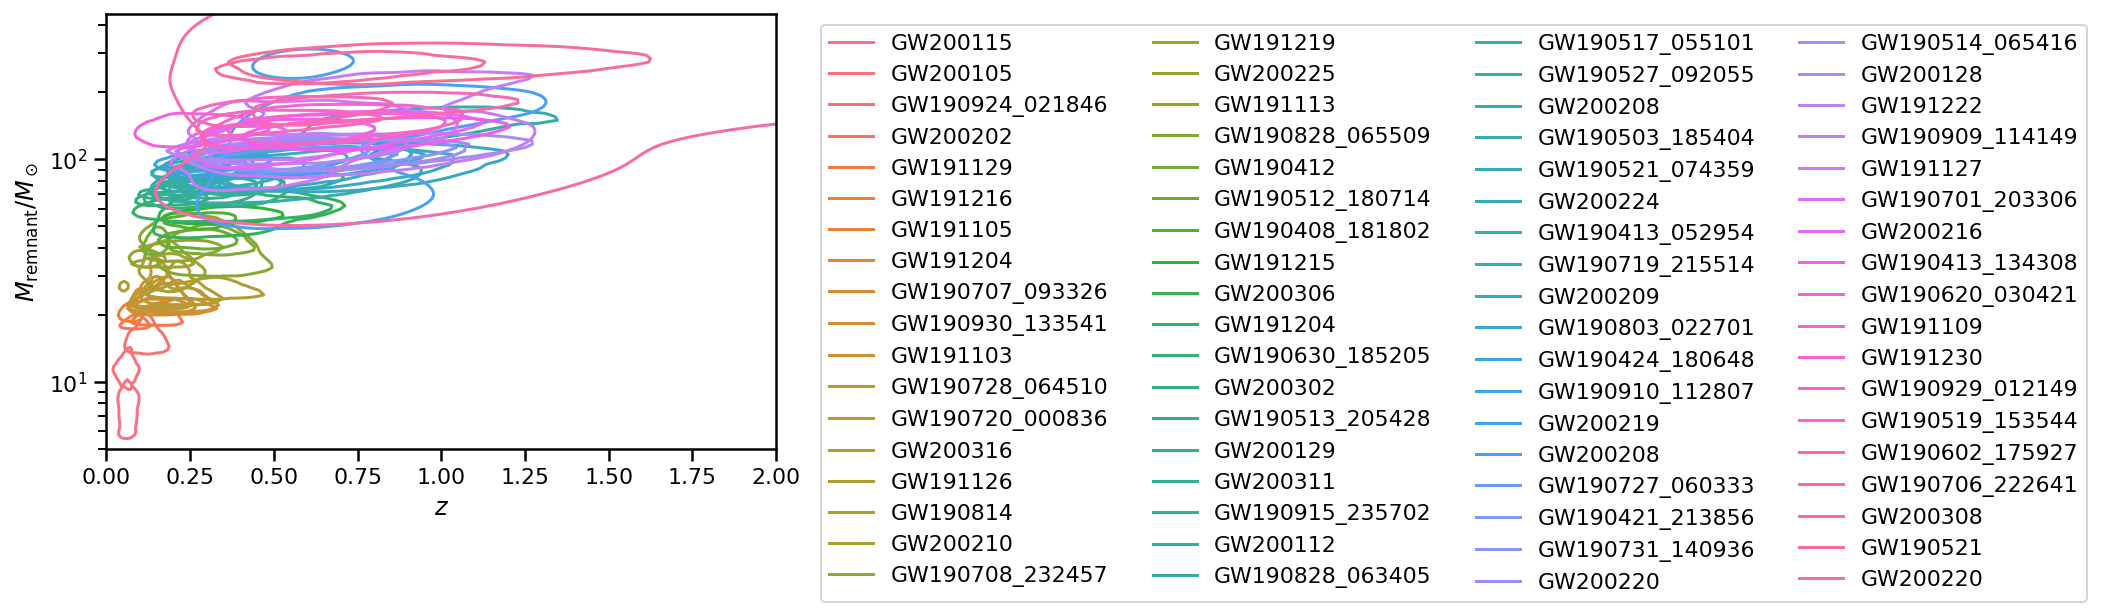

In [37]:
ms = [np.median(s['final_mass']) for s in samples]
inds = np.argsort(ms)

names_sorted = []
samples_sorted = []
for i in inds:
    names_sorted.append(names[i])
    samples_sorted.append(samples[i])

Ngrid = 128
ms = np.exp(np.linspace(np.log(5), np.log(450), Ngrid))
zs = np.expm1(np.linspace(np.log(1), np.log(1+2), Ngrid))

leg_handles = []
with sns.color_palette('husl', n_colors=len(samples_sorted)):
    for i, (n,s) in tqdm(enumerate(zip(names_sorted, samples_sorted)), total=len(samples_sorted)):
        pts = np.row_stack((np.log(s['final_mass']), s['redshift']))
        inds = np.random.choice(pts.shape[1], 256, replace=False)
        test_pts = pts[:, inds]
        kde = gaussian_kde(pts)

        MS = ms[None, :]
        ZS = zs[:, None]
        MS, ZS = np.broadcast_arrays(MS, ZS)
        PS = np.reshape(kde(np.row_stack((np.log(MS.ravel()), ZS.ravel()))), MS.shape)
        l = kde_credible_level(kde, test_pts, 0.1)
        plt.contour(ZS, MS, PS, levels=[l], colors=[sns.color_palette()[i]])
        leg_handles.append(mlines.Line2D([], [], color=sns.color_palette()[i], label=n))
    plt.yscale('log')
    plt.legend(handles=leg_handles, bbox_to_anchor=(1.05, 1), ncol=4, loc='upper left')
    plt.xlabel('$z$')
    plt.ylabel(r'$M_\mathrm{remnant} / M_\odot$')
    plt.savefig('/Users/wfarr/Downloads/mrem-z.pdf')